In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# Load the data
df = pd.read_excel('full_training_df.xlsx')

df.head()

,339.2,340.6,342.1,343.5,345,346.5,347.9,349.4,350.8,352.3,...,2501.1,2503.1,2505.2,2507.3,2509.4,2511.4,2513.5,2515.6,Water Potential (Mpa),RWC
0,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,0.0722,...,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405,-0.326122,98.373025
1,0.0889,0.1040,0.1000,0.1056,0.0896,0.0839,0.0836,0.0877,0.0831,0.0723,...,0.0368,0.0344,0.0330,0.0349,0.0334,0.0332,0.0340,0.0356,-0.147548,99.923489
2,0.0889,0.1000,0.0960,0.1056,0.1034,0.0866,0.0705,0.0767,0.0860,0.0691,...,0.0602,0.0562,0.0530,0.0565,0.0567,0.0546,0.0535,0.0551,-0.296475,89.123574
3,0.1511,0.1333,0.1280,0.1283,0.1172,0.1266,0.1117,0.0876,0.0961,0.0938,...,0.0539,0.0540,0.0530,0.0520,0.0509,0.0510,0.0522,0.0551,-0.919761,91.801013
4,0.1422,0.1021,0.1098,0.0905,0.0912,0.0590,0.0727,0.0901,0.0830,0.0915,...,0.0505,0.0537,0.0505,0.0471,0.0492,0.0469,0.0443,0.0540,-0.383349,88.695652


In [3]:
# ---------------------------------
# Define predictors and response
# ---------------------------------
predictors = df.drop(columns = ['Water Potential (Mpa)', 'RWC'])
response = df['RWC']

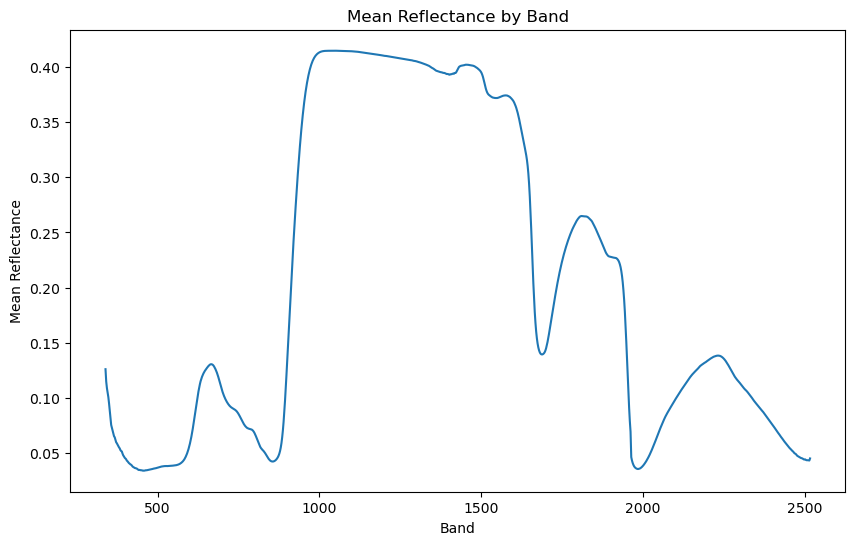

In [4]:
# Compute the step size required to have 994 bands within the range
start_band = 339
end_band = 2516
num_bands = 994
step_size = (end_band - start_band) / (num_bands - 1)

# Create a numpy array of the band values with 994 bands
bands = np.arange(start_band, end_band + step_size, step_size)

# Plot a line plot where the x-axis is the bands and y-axis is the mean of the features
plt.figure(figsize=(10, 6))
plt.plot(bands, predictors.mean(axis=0))
plt.xlabel('Band')
plt.ylabel('Mean Reflectance')
plt.title('Mean Reflectance by Band')
plt.show()

# Savitzky-Golay filter

In [5]:
from scipy import signal
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline

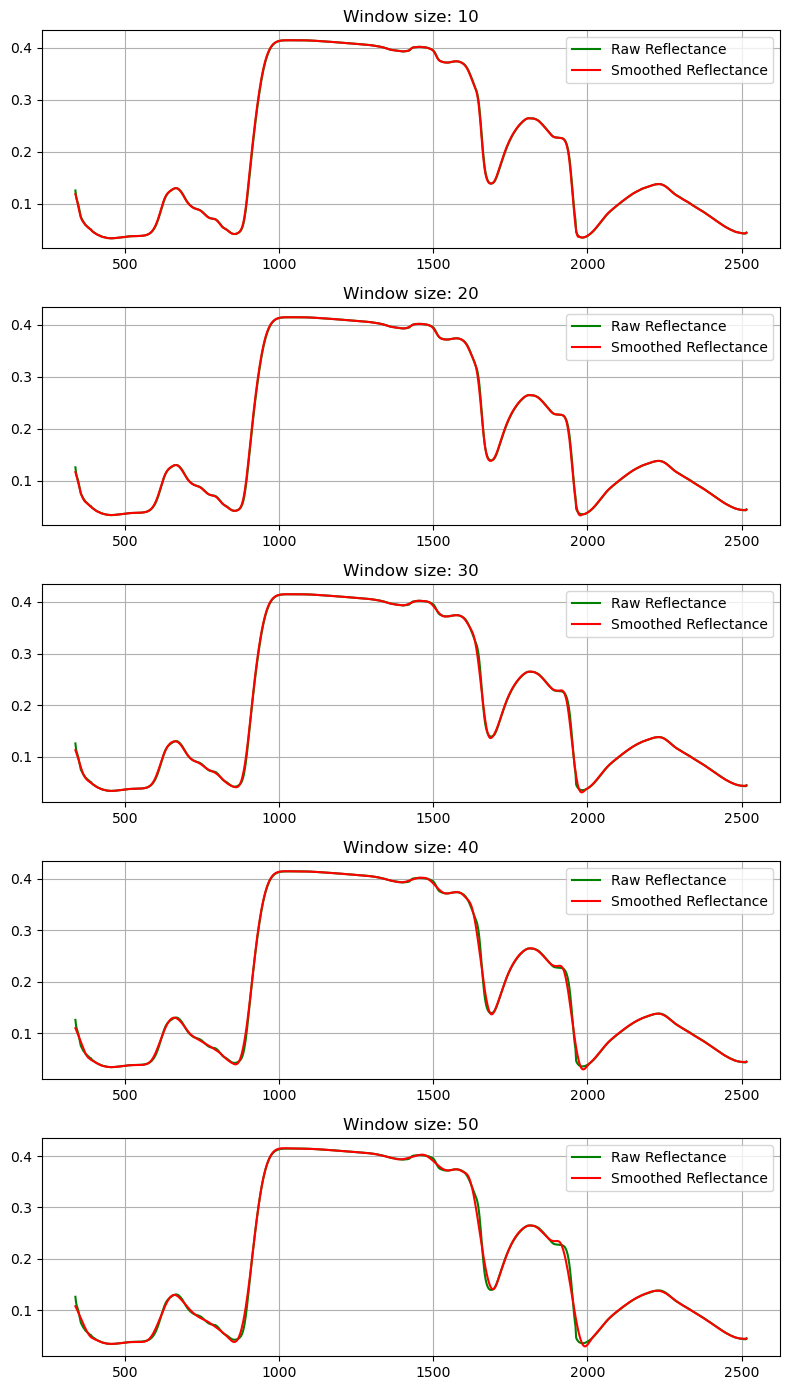

In [6]:
ig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 
# define window sizes 10, 20, 30, 40, 50
for w_size in [10, 20, 30, 40, 50]:    
    X_smooth = signal.savgol_filter(predictors, w_size, 3, mode="nearest")
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth.mean(axis=0), label="Smoothed Reflectance", color="red")
    ax[i].set_title("Window size: " + str(w_size))
    ax[i].legend()
    ax[i].grid(True)
    i+=1

plt.tight_layout()        
plt.show() 

# Gaussian Kernel Smoother

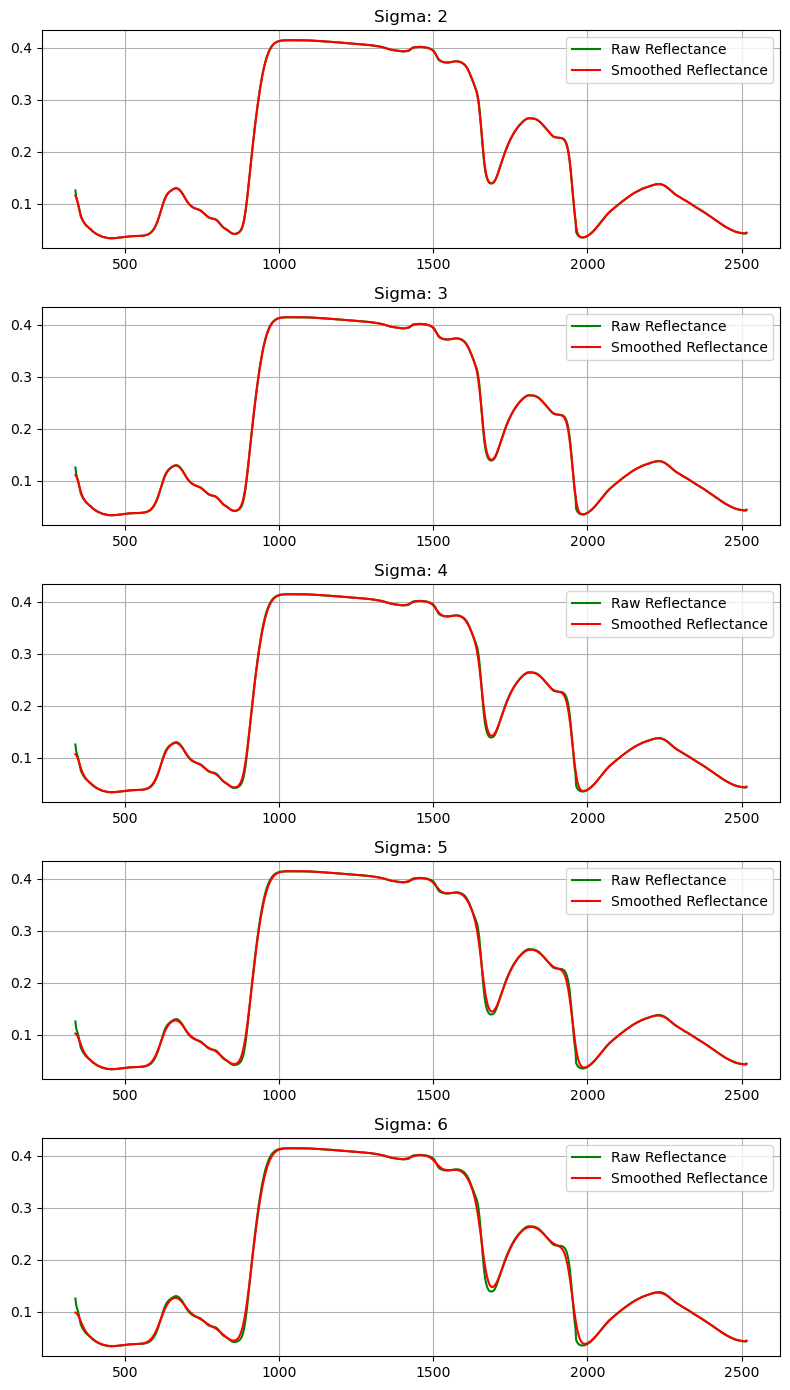

In [7]:
fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# define sigma values 1, 2, 3, 4, 5
for sigma in [2, 3, 4, 5, 6]:    
    X_smooth = gaussian_filter1d(predictors.mean(axis=0), sigma)
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth, label="Smoothed Reflectance", color="red")
    ax[i].set_title("Sigma: " + str(sigma))
    ax[i].legend()
    ax[i].grid(True)
    i+=1

plt.tight_layout()        
plt.show() 

# Kalman filter

In [8]:
!pip install filterpy

ValueError: x and y must have same first dimension, but have shapes (994,) and (176,)

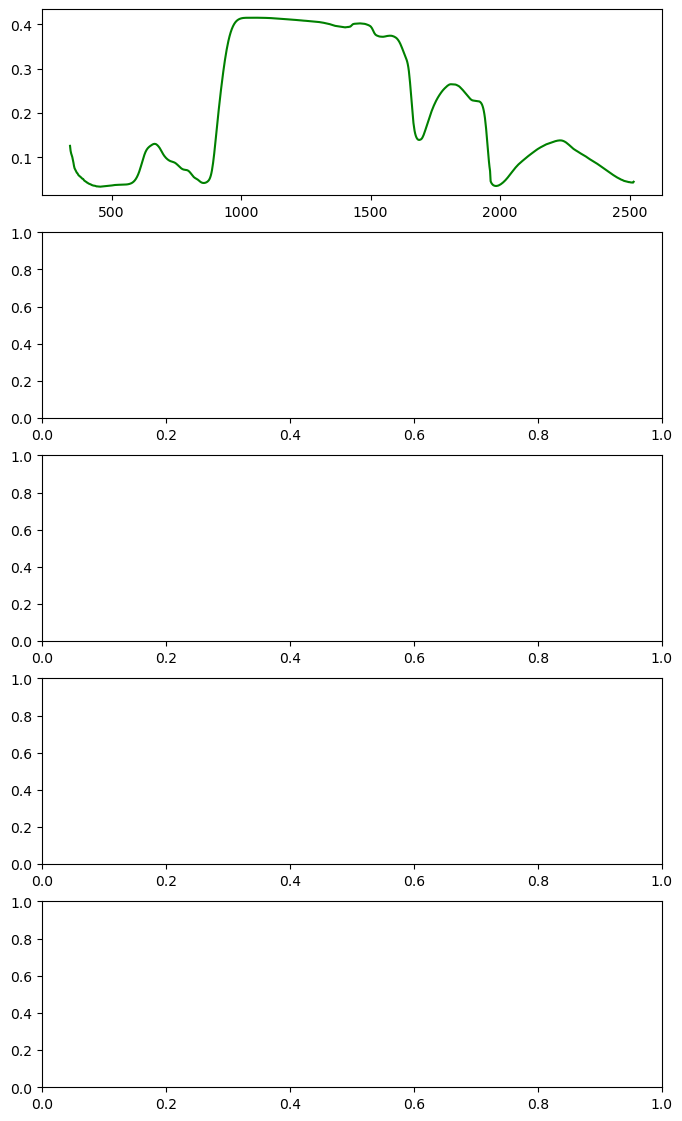

In [9]:
# Initialize Kalman filter parameters
from filterpy.kalman import KalmanFilter

# Convert predictors to a NumPy array
predictors_array = predictors.to_numpy()

# Plotting
fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# Define sigma values
sigmas = [2, 3, 4, 5, 6]

# Loop over sigma values
for sigma in sigmas:    
    # Smooth the data using the Kalman filter
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = np.array([[1, 1], [0, 1]])
    kf.H = np.array([[1, 0]])
    kf.Q = np.eye(2) * 0.01
    kf.R = np.eye(1) * 0.1
    kf.x = np.array([0, 0])
    kf.P = np.eye(2)
    
    # Clear X_smoothed for each iteration
    X_smoothed = []
    
    for measurement in predictors.T:
        kf.predict()
        kf.update(measurement)
        X_smoothed.append(kf.x[0])
    
    # Plot original and smoothed data
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smoothed, label="Smoothed Reflectance (Kalman Filter)", color="red")
    ax[i].set_title("Sigma: " + str(sigma))
    ax[i].legend()
    ax[i].grid(True)
    i += 1

plt.tight_layout()        
plt.show()

# Wiener Filter

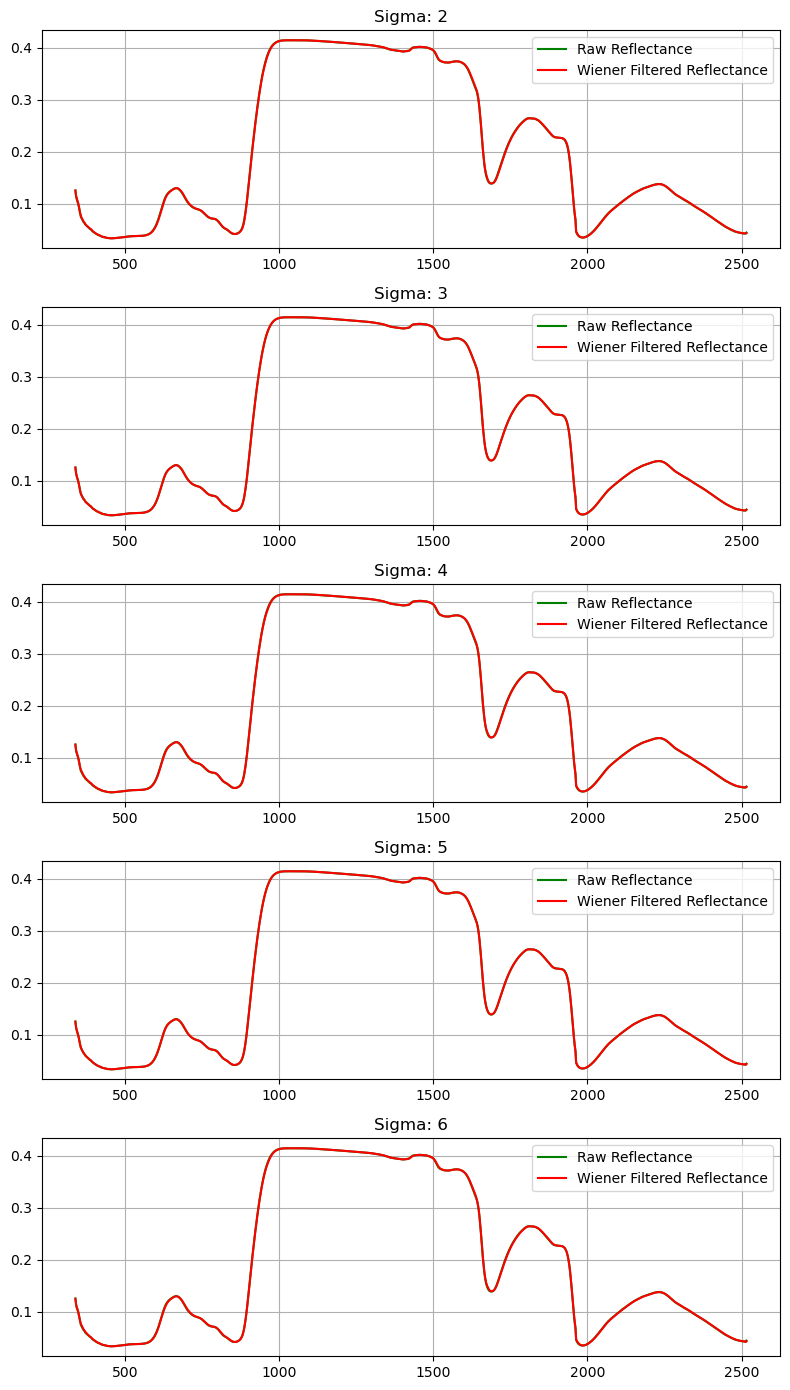

In [10]:
from scipy.signal import wiener

# Plotting
fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# Define sigma values
sigmas = [2, 3, 4, 5, 6]

# Loop over sigma values
for sigma in sigmas:    
    # Apply Wiener filtering
    X_smooth = wiener(predictors.mean(axis=0), mysize=sigma)
    
    # Plot original and smoothed data
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth, label="Wiener Filtered Reflectance", color="red")
    ax[i].set_title("Sigma: " + str(sigma))
    ax[i].legend()
    ax[i].grid(True)
    i += 1

plt.tight_layout()        
plt.show()


# Median Filter

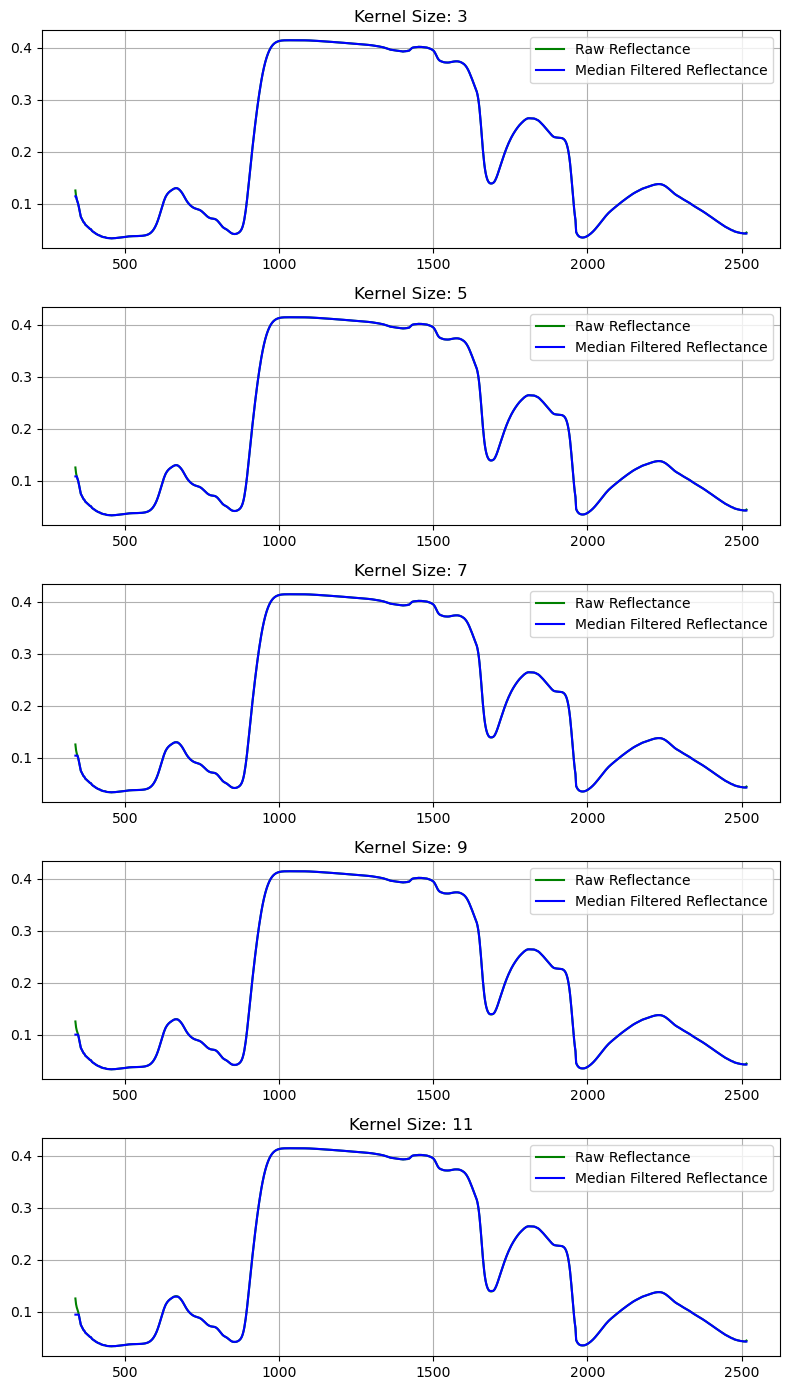

In [11]:
from scipy.signal import medfilt

fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# Define kernel sizes for median filter
kernel_sizes = [3, 5, 7, 9, 11]

# Loop over kernel sizes
for kernel_size in kernel_sizes:    
    # Apply median filtering
    X_smooth = medfilt(predictors.mean(axis=0), kernel_size)
    
    # Plot original and smoothed data
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth, label="Median Filtered Reflectance", color="blue")
    ax[i].set_title("Kernel Size: " + str(kernel_size))
    ax[i].legend()
    ax[i].grid(True)
    i += 1

plt.tight_layout()        
plt.show()
